In [14]:
!pip install flwr==0.17.0
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/PartIII/L46

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/PartIII/L46'
/content/drive/MyDrive/PartIII/L46


In [15]:
!ls

cifar-10-batches-py	cifar.py   clients.sh  __pycache__  server.sh
cifar-10-python.tar.gz	client.py  logs        server.py


In [16]:
%%writefile cifar.py

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10

from flwr_experimental.baseline.dataset.dataset import create_partitioned_dataset

class PartitionedDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (self.X[idx], int(self.Y[idx]))


def load_data():

    """Load CIFAR-10 (training and test set)."""
    transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10(".", train=True, download=True, transform=transform)
    testset = CIFAR10(".", train=False, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
    testloader = DataLoader(testset, batch_size=32)
    num_examples = {"trainset" : len(trainset), "testset" : len(testset)}
    return trainset, testset, num_examples

def load_local_partitioned_data(client_id, iid_fraction: float, num_partitions: int):
    """Creates a dataset for each worker, which is a partition of a larger dataset."""
    
    # Each worker loads the entire dataset, and then selects its partition
    # determined by its `client_id` (happens internally below)
    trainset, testset, num_examples = load_data()
    
    train_loader = DataLoader(trainset, batch_size=len(trainset))
    test_loader = DataLoader(testset, batch_size=len(testset))

    (x_train, y_train), (x_test, y_test) = next(iter(train_loader)), next(iter(test_loader))
    x_train, y_train = x_train.numpy(), y_train.numpy()
    x_test, y_test = x_test.numpy(), y_test.numpy()

    (train_partitions, test_partitions), _ = create_partitioned_dataset(
        ((x_train, y_train), (x_test, y_test)), iid_fraction, num_partitions)
 
    x_train, y_train = train_partitions[client_id]
    torch_partition_trainset = PartitionedDataset(torch.Tensor(x_train), y_train)
    x_test, y_test = test_partitions[client_id]
    torch_partition_testset = PartitionedDataset(torch.Tensor(x_test), y_test )
    return torch_partition_trainset, torch_partition_testset

Overwriting cifar.py


In [17]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [31]:
%%writefile client.py

from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
import grpc
import argparse
from tqdm import tqdm

import cifar
import pickle
import flwr as fl

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(net, trainloader, epochs):
    """Train the network on the training set."""
    log_progress = True
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    results = []

    for epoch in range(epochs):
        total_loss, total_correct, n_samples = 0.0, 0.0, 0
        pbar = tqdm(trainloader, desc=f'TRAIN Epoch {epoch}') if log_progress else trainloader
        for images, labels in pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) 
            n_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            if log_progress:
                pbar.set_postfix({
                    "train_loss": total_loss/n_samples, 
                    "train_acc": total_correct/n_samples
                })

        results.append((total_loss/n_samples, total_correct/n_samples))   
    return results

def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    log_progress = True

    with torch.no_grad():
        pbar = tqdm(testloader, desc="TEST") if log_progress else testloader
        for data in pbar:
            images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return loss / total, accuracy

class BaseNet(nn.Module):
    def __init__(self) -> None:
        super(BaseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        return x
  
# class BaseNet2(nn.Module):
#     def __init__(self):


class PersonalNet(nn.Module):
    def __init__(self) -> None:
        super(PersonalNet, self).__init__()
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class FullModel(nn.Module):
    def __init__(self, base, personal) -> None:
        super(FullModel, self).__init__()
        self.base = base
        self.personal = personal
    def forward(self, x):
        x = self.base(x)
        x = self.personal(x)
        return x
    def get_weights(self):  
        return [val.cpu().numpy() for _, val in self.state_dict().items()]
    def set_weights(self, weights):
        state_dict = OrderedDict(
            {k: torch.Tensor(v) for k, v in zip(self.state_dict().keys(), weights)}
        )
        self.load_state_dict(state_dict, strict=True)

# trainloader, testloader, num_examples = cifar.load_data()

class CifarClient(fl.client.NumPyClient):

    def __init__(self, cid, base_model, personal_net, fullnet, trainset, testset):
        self.cid = cid
        self.base_model = base_model
        self.personal_net = personal_net
        self.fullnet = fullnet
        self.trainset = trainset
        self.testset = testset

    def get_parameters(self):
        return [val.cpu().numpy() for _, val in self.base_model.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.base_model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.base_model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        trainloader = DataLoader(self.trainset, batch_size=32, shuffle=True)
        self.set_parameters(parameters)
        train_log = train(self.fullnet, trainloader, epochs=10)

        train_loss, train_acc = train_log[-1]
        print(f'Client {self.cid}: train_loss={train_loss:.4f}, train_accuracy={train_acc:.4f}')
        round = int(config['epoch_global']) // int(config['epochs']) + 1
        with open(f'logs/client_{self.cid}/training_round_{round}', 'wb') as fp:
            pickle.dump(train_log, fp)

        return self.get_parameters(), len(trainloader), {}

    def evaluate(self, parameters, config):

        testloader = DataLoader(self.testset, batch_size=32, shuffle=False)

        self.set_parameters(parameters)
        test_loss, test_acc = test(self.fullnet, testloader)
        print(f"Client {self.cid}: test_loss={test_loss:.4f}, test_accuracy={test_acc:.4f}")
        round = int(config['epoch_global']) // int(config['epochs']) + 1
        with open(f'logs/client_{self.cid}/testing_round_{round}', 'wb') as fp:
            pickle.dump([test_loss, test_acc], fp)
        return float(test_loss), len(testloader), {"accuracy": float(test_acc)}

def load_model():
    return FullModel(BaseNet(),PersonalNet())

def start_client(client_id, basenet=None, fullnet=None, personalnet=None, num_partitions=10, iid_fraction=1.0, 
                 server_address="localhost:8080", log_host=None):
    # Configure logger
    fl.common.logger.configure(f"client_{client_id}", host=log_host)

    print(f"Loading data for client {client_id}")
    trainset, testset = cifar.load_local_partitioned_data(
        client_id=client_id, 
        iid_fraction=iid_fraction, 
        num_partitions=num_partitions)
    

    # Start client
    print(f"Starting client {client_id}")
    client = CifarClient(client_id, basenet, personalnet, fullnet, trainset, testset)
    # f'{exp_name}_iid-fraction_{iid_fraction}')

    print(f"Connecting to {server_address}")

    try:
        # There's no graceful shutdown when gRPC server terminates, so we try/except
        fl.client.start_numpy_client(server_address, client)
    except grpc._channel._MultiThreadedRendezvous:
        print(f"Client {client_id}: shutdown")



if __name__ == "__main__":
    num_clients = 10
    num_partitions = 10
    iid_fraction = 0.1

    parser = argparse.ArgumentParser(description="Flower client")
    parser.add_argument("--cid", type=int, required=True, help="Client CID (no default)")

    args, _ = parser.parse_known_args()

    basenet = BaseNet().to(DEVICE)
    personalnet = PersonalNet().to(DEVICE)
    fullnet = FullModel(basenet, personalnet)
    
    # fl.client.start_numpy_client("localhost:8080", client=CifarClient(100,basenet,personalnet,fullnet,0,0))
    start_client(client_id=args.cid, basenet=basenet, fullnet=fullnet, personalnet=personalnet, num_partitions=num_partitions, iid_fraction=iid_fraction, server_address="localhost:24338")
    print(f"Started {num_clients} clients")


Overwriting client.py


In [32]:
%%writefile server.py

import flwr as fl
from flwr.server.grpc_server.grpc_server import start_insecure_grpc_server
import cifar
import client

DEFAULT_SERVER_ADDRESS = "localhost:24338"

fl.common.logger.configure("server", host=None)

rounds = 3
epochs = 10
batch_size = 32

_, testset, _ = cifar.load_data()

def get_eval_fn(testset):
    """Returns an evaluation function for centralized (server-side) evaluation."""
    def evaluate(weights: fl.common.Weights):
        """Use the entire CIFAR-10 test set for evaluation."""
        model = client.load_model()
        model.set_weights(weights)
        model.to(DEVICE)
        testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
        loss, accuracy = client.test(net=model, testloader=testloader, device=DEVICE, log_progress=True)
        return loss, {"accuracy": accuracy}
    return evaluate

def generate_config(epochs, batch_size):
    def fit_config(round: int):
        print(f"Configuring round {round}...")
        return {
            "epoch_global": str((round - 1) * epochs),
            "epochs": str(epochs),
            "batch_size": str(batch_size),
        }
    return fit_config 

strategy = fl.server.strategy.FedAvg(
    min_fit_clients=10,
    min_eval_clients=10,
    min_available_clients=10,
    # eval_fn=get_eval_fn(testset),
    on_fit_config_fn=generate_config(epochs, batch_size),
    on_evaluate_config_fn=generate_config(epochs, batch_size),
)

client_manager = fl.server.SimpleClientManager()
server = fl.server.Server(client_manager=client_manager, strategy=strategy)

# fl.server.start_server(config={"num_rounds": 3}, strategy=strategy)

print(f"Starting gRPC server on {DEFAULT_SERVER_ADDRESS}...")
grpc_server = start_insecure_grpc_server(
        client_manager=server.client_manager(),
        server_address=DEFAULT_SERVER_ADDRESS,
        max_message_length=fl.common.GRPC_MAX_MESSAGE_LENGTH,
    )

print("Fitting the model...")
hist = server.fit(num_rounds=3)
# test_loss, test_metrics = server.strategy.evaluate(parameters=server.parameters)
# print(f"Server-side test results after training: test_loss={test_loss:.4f}, "
#         f"test_accuracy={test_metrics['accuracy']:.4f}")

grpc_server.stop(None)    
# fl.server.start_server(config={"num_rounds": 3})

Overwriting server.py


In [33]:
%%writefile server.sh

PYTHONUNBUFFERED=1 python3 server.py --rounds=3 --epochs=10 --sample_fraction=1 --min_sample_size=5  --min_num_clients=5  --server_address="localhost:24338"

Overwriting server.sh


In [34]:
%%writefile clients.sh

export PYTHONUNBUFFERED=1
NUM_CLIENTS=10 # TODO: change the number of clients here


echo "Starting $NUM_CLIENTS clients."
for ((i = 0; i < $NUM_CLIENTS; i++))
do
    echo "Starting client(cid=$i) with partition $i out of $NUM_CLIENTS clients."
    # Staggered loading of clients: clients are loaded 8s apart.
    # At the start, each client loads the entire CIFAR-10 dataset before selecting
    # their own partition. For a large number of clients this causes a memory usage
    # spike that can cause client processes to get terminated. 
    # Staggered loading prevents this.
    sleep 20s  
    python3 client.py \
      --cid=$i \
      --num_partitions=${NUM_CLIENTS} &
done
echo "Started $NUM_CLIENTS clients."

Overwriting clients.sh


In [35]:
# Execute this after running any of the %%writefile cells above
!chmod +x clients.sh server.sh

In [36]:
%killbgscripts
!((./server.sh & sleep 8s); ./clients.sh)

All background processes were killed.
Files already downloaded and verified
Files already downloaded and verified
Starting 10 clients.
Starting client(cid=0) with partition 0 out of 10 clients.
Starting gRPC server on localhost:24338...
Fitting the model...
INFO flower 2022-01-03 15:16:28,112 | server.py:118 | Initializing global parameters
INFO flower 2022-01-03 15:16:28,112 | server.py:304 | Requesting initial parameters from one random client
Starting client(cid=1) with partition 1 out of 10 clients.
Loading data for client 0
Files already downloaded and verified
Files already downloaded and verified
Starting client(cid=2) with partition 2 out of 10 clients.
Loading data for client 1
Files already downloaded and verified
Starting client 0
Connecting to localhost:24338
DEBUG flower 2022-01-03 15:17:14,513 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-01-03 15:17:14,514 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-01-03 15:17:14,515 | app.py:61 | O

In [27]:
import pickle
import glob
import numpy as np

num_clients = 10
num_rounds = 3

all_files = []
for file in glob.glob("logs/*"):
    all_files.append(file)

print(all_files)

train_losses = [[0] * 30 for i in range(num_clients)]
train_accs = [[0] * 30 for i in range(num_clients)]

for client_id in range(num_clients):
    for round_id in range(1, num_rounds+1):
        with open(f'logs/client_{client_id}/training_round_{round_id}', 'rb') as fp:
            results = np.asarray(pickle.load(fp))
            train_losses[client_id][(round_id-1)*10:round_id*10] = results[:,0]
            train_accs[client_id][(round_id-1)*10:round_id*10] = results[:,1]

test_losses = [[0] * 3 for i in range(num_clients)]
test_accs = [[0] * 3 for i in range(num_clients)]

for client_id in range(num_clients):
    for round_id in range(1, num_rounds+1):
        with open(f'logs/client_{client_id}/testing_round_{round_id}', 'rb') as fp:
            results = np.asarray(pickle.load(fp))
            test_losses[client_id][round_id-1] = results[0]
            test_accs[client_id][round_id-1] = results[1]

['logs/client_1', 'logs/client_2', 'logs/client_3', 'logs/client_4', 'logs/client_0', 'logs/client_5', 'logs/client_6', 'logs/client_7', 'logs/client_8', 'logs/client_9', 'logs/standard_iid_0.5', 'logs/standard_iid_0.75', 'logs/standard_iid_0.25', 'logs/standard_iid_1', 'logs/standard_iid_0.1', 'logs/reversed_model_iid_0.5', 'logs/reversed_model_iid_0.1', 'logs/small_base_iid_0.5', 'logs/large_base_iid_0.5', 'logs/medley_base_iid_0.5', 'logs/large_base_iid_0.1']


In [ ]:
test_losses

[[0.06611644423007965, 0.05670306813716888, 0.050971031665802004],
 [0.07082808494567872, 0.06596984422206878, 0.0555262656211853],
 [0.06851301002502441, 0.05974188959598541, 0.05238166284561157],
 [0.06947494435310364, 0.06052490782737732, 0.052724830508232116],
 [0.06730612182617188, 0.057494162440299985, 0.05055581223964691],
 [0.06581063175201415, 0.05679802119731903, 0.0522175452709198],
 [0.06906508445739747, 0.06234287548065186, 0.056295003294944766],
 [0.06795336210727691, 0.06009175932407379, 0.054405296564102174],
 [0.067596719622612, 0.05967743170261383, 0.0533522173166275],
 [0.06556041514873505, 0.05557293677330017, 0.04950327515602112]]

In [37]:
experiment_name = 'small_base_iid_0.1'

In [38]:
with open(f'logs/{experiment_name}/train_losses', 'wb') as fp:
    pickle.dump(train_losses, fp)
with open(f'logs/{experiment_name}/train_accs', 'wb') as fp:
    pickle.dump(train_accs, fp)

In [39]:
with open(f'logs/{experiment_name}/test_losses', 'wb') as fp:
    pickle.dump(test_losses, fp)
with open(f'logs/{experiment_name}/test_accs', 'wb') as fp:
    pickle.dump(test_accs, fp)

## Overall configuration

10 clients, 3 rounds, 10 epochs, lr = 0.001, SGD optimizer, momentum=0.9

Standard configuration: Basenet with convolution layers and personalnet with linear layers on the top

    class BaseNet(nn.Module):
        def __init__(self) -> None:
            super(BaseNet, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            # self.fc2 = nn.Linear(120, 84)
            # self.fc3 = nn.Linear(84, 10)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            # x = F.relu(self.fc2(x))
            # x = self.fc3(x)
            return x

    class PersonalNet(nn.Module):
        def __init__(self) -> None:
            super(PersonalNet, self).__init__()
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)
        def forward(self, x: torch.Tensor) -> torch.Tensor:
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


Reversed model configuration: Basenet with linear layers on top and personal net with convolution layers

Medley model configuration: Basenet with

## Plots

In [12]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

files = ['standard_iid_0.1', 'standard_iid_0.25', 'standard_iid_0.5', 'standard_iid_0.75', 'standard_iid_1']
files = ['standard_iid_0.5', 'small_base_iid_0.5', 'large_base_iid_0.5', 'reversed_model_iid_0.5']
test_accs = []
train_losses = []
for file in files:
    with open(f'logs/{file}/test_accs', 'rb') as pf:
        test_acc = pickle.load(pf)
    with open(f'logs/{file}/test_accs', 'rb') as pf:
        test_acc = pickle.load(pf)
    test_accs.append(test_acc)

Text(0, 0.5, 'Test Accuracy')

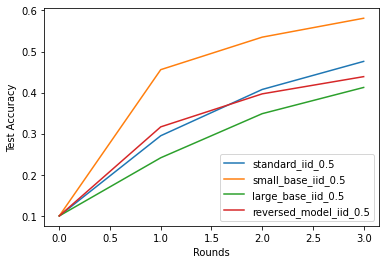

In [13]:
for i, test_acc in enumerate(test_accs):
    label = 'iid_fraction=' + files[i].split('_')[-1]
    plt.plot(range(0,4), np.insert(np.asarray(test_acc).mean(axis=0), 0, 0.1), label=files[i])
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Test Accuracy')

In [ ]:
np.asarray(test_accs[0]).mean(axis=0)

array([0.3643, 0.4746, 0.5383])